In [15]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *
from cell_utilities import *
from learning_utilities import *

In [3]:
alg = 'otsu'

In [4]:
stack = 'MD593'

# Same section, different regions

In [4]:
sec = 200

In [6]:
img_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped_gray')
download_from_s3(img_filename)
img = imread(img_filename)

In [5]:
fn = metadata_cache['sections_to_filenames'][stack][sec]

# Load mask
t = time.time()
mask_tb = DataManager.load_thumbnail_mask_v2(stack=stack, fn=fn)
mask = resize(mask_tb, metadata_cache['image_shape'][stack][::-1]) > .5
sys.stderr.write('Load mask: %.2f\n' % (time.time() - t) )

if alg == 'otsu':
    labelmap = load_cell_data(stack=stack, sec=sec, what='labelmap_otsu', ext='bp')
    labelmap[~mask] = 0

elif alg == 'cellprofiler':
    labelmap = load_cell_data(stack=stack, sec=sec, what='image_inverted_labelmap_cellprofiler', ext='bp')
    labelmap[~mask] = 0

elif alg == 'farsight':
    labelmap = load_cell_data(stack=stack, sec=sec, what='image_inverted_labelmap_farsight', ext='bp')
    labelmap[~mask] = 0

else:
    raise 'Algorithm not recognized.'

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Load mask: 6.25


In [7]:
all_regions = get_random_masked_regions(region_shape=(500,500), num_regions=2, stack=stack, sec=sec)

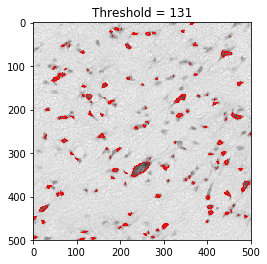

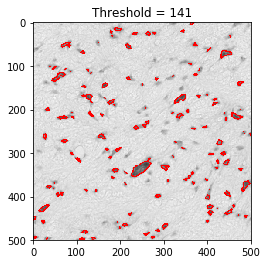

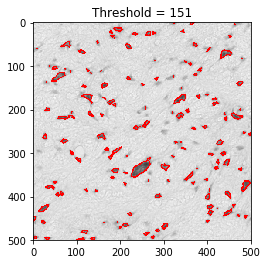

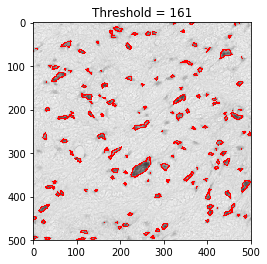

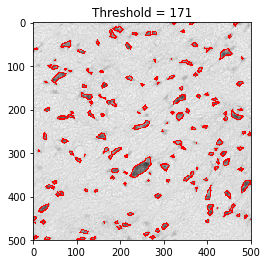

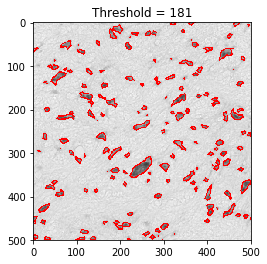

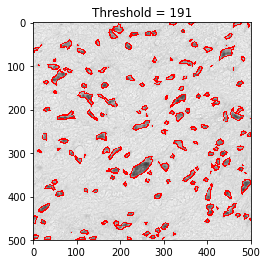

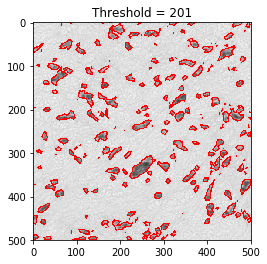

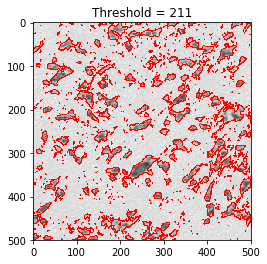

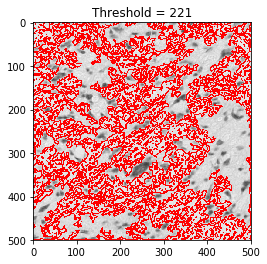

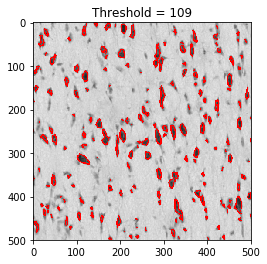

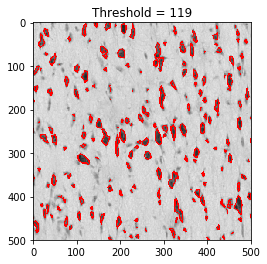

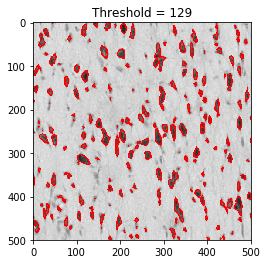

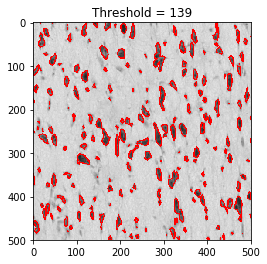

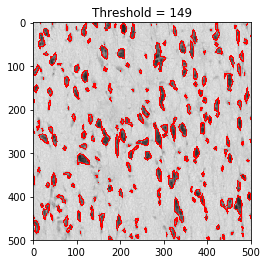

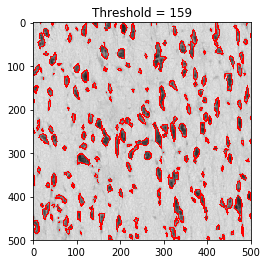

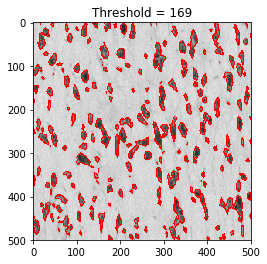

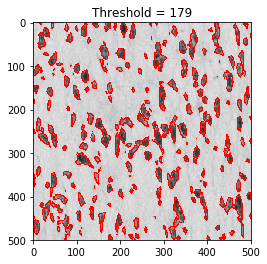

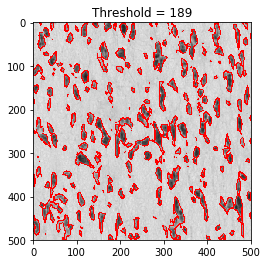

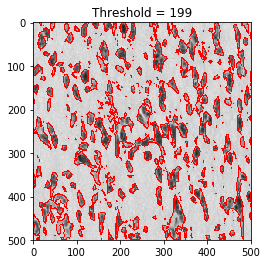

In [9]:
for region_x, region_y, region_w, region_h in all_regions:
    img_cropped = img[region_y:region_y+region_h, region_x:region_x+region_w]
    
    thresh_otsu = threshold_otsu(img_cropped)
    
    for threshold in np.arange(thresh_otsu-50, thresh_otsu+50, 10):
        viz = visualize_blob_contour(binary_img=img_cropped<threshold, bg_img=img_cropped)
        plt.imshow(viz, plt.cm.gray, vmin=0, vmax=255);
        plt.title('Threshold = %d' % threshold);
        plt.show();

# Adjacent section, same regions

In [16]:
sec_groups = [(200, 201, 202, 203)]

In [17]:
region_w = 500
region_h = 500

In [18]:
min_blob_area = 10
max_blob_area = 10000

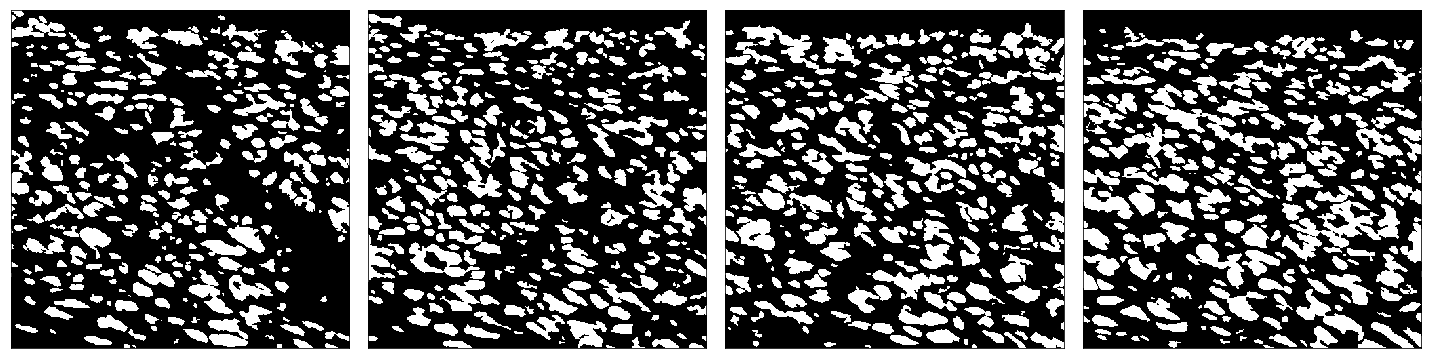

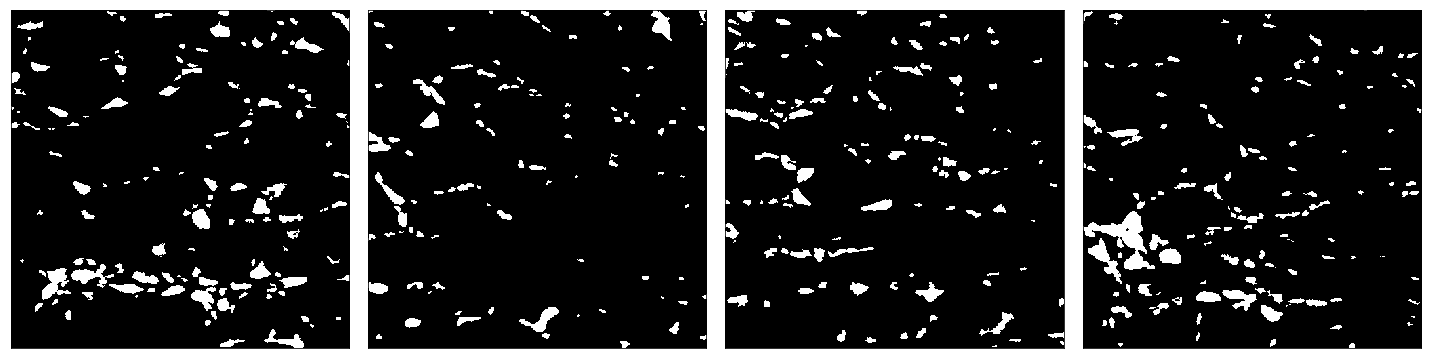

In [19]:
for i, sec_group in enumerate(sec_groups):
    
    tb_mask = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec_group[0])

    all_regions = get_random_masked_regions(region_shape=(region_w, region_h), stack=stack, sec=sec_group[0], num_regions=2)
    
    images = {sec: imread(DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped_gray'))
              for sec in sec_group}
    
    otsu_images_all_regions = []
    for region_x, region_y, region_w, region_h in all_regions:
        images_same_region = [images[sec][region_y:region_y+region_h, region_x:region_x+region_w]
                              for sec in sec_group]
        
        otsu_images_same_region = []
        for img in images_same_region:
            otsu_t = threshold_otsu(img)
            binary_img = img < otsu_t
            binary_img = remove_small_objects(binary_img, min_size=min_blob_area, connectivity=2)
            binary_img = remove_small_holes(binary_img, min_size=min_blob_area, connectivity=2)
            otsu_images_same_region.append(binary_img)
            
#         display_images_in_grids(images_same_region, nc=len(sec_group), cmap=plt.cm.gray)
        otsu_images_all_regions.append(otsu_images_same_region)
        display_images_in_grids(otsu_images_same_region, nc=len(sec_group), cmap=plt.cm.gray)